# Deep Scientific Validation: eos0bbb (Permeability & Efflux GNN-MTL)

This notebook validates that the Chemprop multitask MPNN model produces **scientifically meaningful** predictions for four ADME endpoints:
1. **Caco-2 ER** — efflux ratio (log10)
2. **Caco-2 P_app** — apparent permeability (log10, ×10⁻⁶ cm/s)
3. **MDCK ER** — efflux ratio (log10)
4. **NIH-MDCK ER** — efflux ratio (log10)

**Three validation layers:**
1. **Distribution Analysis** — Run 50 diverse molecules, check output statistics
2. **Sanity Checks** — Verify high-permeability drugs score higher than low-permeability compounds
3. **Paper Reproduction** — Compare model behavior against known pharmacological properties

## Setup

In [1]:
# Install dependencies if needed (uncomment to run)
# !pip install chemprop==2.1.0

In [2]:
import os
import csv
import time
import json
import tempfile
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import torch
from chemprop import data, featurizers, models, nn

sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (12, 5)

# Model paths
MODEL_DIR = Path(".").resolve()
CHECKPOINT = MODEL_DIR / "model" / "checkpoints" / "model.pt"
MAIN_PY = MODEL_DIR / "model" / "framework" / "code" / "main.py"

COLUMN_NAMES = ["caco2_er", "caco2_papp", "mdck_er", "nih_mdck_er"]

print(f"Model directory: {MODEL_DIR}")
print(f"Checkpoint exists: {CHECKPOINT.exists()}")
print(f"Output dimensions: {len(COLUMN_NAMES)}")

Model directory: /Users/tensor/dev/ersilia-os/ersilia/eos0bbb
Checkpoint exists: True
Output dimensions: 4


In [3]:
def load_model():
    """Load the Chemprop GNN-MTL model from checkpoint."""
    ckpt = torch.load(str(CHECKPOINT), map_location="cpu", weights_only=False)
    state_dict = ckpt["state_dict"]
    mean = state_dict["predictor.output_transform.mean"].squeeze()
    scale = state_dict["predictor.output_transform.scale"].squeeze()
    
    mp = nn.BondMessagePassing(d_h=300, depth=3)
    agg = nn.MeanAggregation()
    output_transform = nn.UnscaleTransform(mean=mean, scale=scale)
    ffn = nn.RegressionFFN(
        input_dim=300, hidden_dim=300, n_layers=1, n_tasks=4,
        output_transform=output_transform
    )
    model = models.MPNN(mp, agg, ffn)
    model.load_state_dict(state_dict)
    model.eval()
    return model


def run_model(smiles_list):
    """Run the model on a list of SMILES, return DataFrame and elapsed time."""
    t0 = time.time()
    test_data = [data.MoleculeDatapoint.from_smi(s) for s in smiles_list]
    feat = featurizers.SimpleMoleculeMolGraphFeaturizer()
    test_dset = data.MoleculeDataset(test_data, feat)
    test_loader = data.build_dataloader(test_dset, shuffle=False)
    
    all_preds = []
    with torch.inference_mode():
        for batch in test_loader:
            bmg = batch.bmg
            preds = model(bmg)
            all_preds.append(preds.numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    elapsed = time.time() - t0
    df = pd.DataFrame(all_preds, columns=COLUMN_NAMES)
    return df, elapsed


model = load_model()
print("Model loaded successfully.")

Model loaded successfully.


/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/chemprop/nn/transforms.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.cat([torch.zeros(pad), torch.tensor(mean, dtype=torch.float)])
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/chemprop/nn/transforms.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.cat([torch.ones(pad), torch.tensor(scale, dtype=torch.float)])


---
## 1. Distribution Analysis

Run the model on **50 diverse molecules** spanning different chemical families and analyze the output distribution across all 4 ADME endpoints.

In [4]:
DIVERSE_50 = [
    "CC(=O)Oc1ccccc1C(=O)O",                          # aspirin
    "CC(C)Cc1ccc(cc1)C(C)C(=O)O",                     # ibuprofen
    "CC(=O)Nc1ccc(O)cc1",                              # acetaminophen
    "OC(=O)c1cc(O)c(O)c(O)c1",                        # gallic acid
    "CC12CCC3(C(CCC4=CC(=O)CCC34C)C1CCC2O)C",        # testosterone
    "c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34",                # pyrene
    "CCCCCCCCCCCCCCCCCCCC",                            # eicosane
    "CCO",                                             # ethanol
    "c1ccccc1",                                        # benzene
    "CC(=O)O",                                         # acetic acid
    "OC(=O)CC(O)(CC(=O)O)C(=O)O",                     # citric acid
    "CC(C)(C)NCC(O)c1ccc(O)c(CO)c1",                  # salbutamol
    "CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21",            # diazepam
    "Oc1ccc(cc1)C(O)(c1ccc(O)cc1)c1ccc(O)cc1",       # triphenol
    "CC(C)(O)C#C",                                     # methylbutynol
    "OC(=O)c1ccccc1O",                                 # salicylic acid
    "c1ccc(cc1)c1ccccc1",                              # biphenyl
    "CCCCCCCCCCCC",                                    # dodecane
    "CC(=O)OC1CC2CCC1(C)C2(C)C",                      # bornyl acetate
    "ClC(Cl)Cl",                                       # chloroform
    "CC1(C)CCC(CC1)OC(=O)c1ccccc1O",                  # homosalate
    "Cn1c(=O)c2c(nc(n2C)C)n(C)c1=O",                 # caffeine
    "OC(=O)CCCCC(=O)O",                               # adipic acid
    "CC(=O)OC1=CC2=C(CC1OC(C)=O)C(C)(CO)C1CCC(=O)C1(C)C2", # artemisin deriv
    "Nc1ccc(N)cc1",                                    # p-phenylenediamine
    "CC(C)CC(=O)O",                                    # isovaleric acid
    "CCOC(=O)c1ccccc1N",                               # benzocaine
    "NC(=O)c1ccc(O)cc1",                               # 4-hydroxybenzamide
    "OC(=O)c1ccc(cc1)C(=O)c1ccc(Cl)cc1",              # chlorobenzoylbenzoic acid
    "CC(=O)c1ccc(cc1)C(C)(C)C",                       # 4-tert-butylacetophenone
    "OC(=O)c1ccncc1",                                  # isonicotinic acid
    "CC(=O)Nc1ccc(cc1)S(N)(=O)=O",                    # sulfacetamide
    "O=C1CCCN1",                                       # pyrrolidone
    "CCCc1nn(C)c2c1nc(nc2O)c1cc(ccc1OCC)S(=O)(=O)N1CCN(CC1)CC", # sildenafil
    "NC(Cc1ccc(O)cc1)C(=O)O",                         # tyrosine
    "CC(CS)C(=O)O",                                    # methylthiopropionic acid
    "OCC(O)C(O)C(O)C(O)CO",                           # mannitol
    "CC(=O)Oc1ccccc1",                                 # phenyl acetate
    "CN1CCN(CC1)C(c1ccccc1)c1ccc(Cl)cc1",             # meclizine fragment
    "OC(=O)c1ccc(O)cc1",                               # 4-hydroxybenzoic acid
    "CC(C)c1ccc(cc1)C(O)CC",                           # ibuprofen alcohol
    "OC(=O)c1cc(=O)c2ccccc2o1",                        # chromone carboxylate
    "c1cc2ccccc2cc1",                                   # naphthalene
    "CCCCN",                                            # butylamine
    "OCC1OC(O)C(O)C(O)C1O",                            # glucose
    "CCc1ccc(cc1)C(C)C(=O)O",                          # 2-ethyl-4-methylphenoxyacetic
    "NC(CCC(=O)O)C(=O)O",                              # glutamic acid
    "O=S(=O)(c1ccc(N)cc1)c1ccc(N)cc1",                # dapsone
    "CC(=O)Nc1nnc(s1)S(N)(=O)=O",                     # acetazolamide
    "CCCCC(CC)COC(=O)c1ccccc1C(=O)OCC(CC)CCCC",       # DEHP
]

DIVERSE_NAMES = [
    "aspirin", "ibuprofen", "acetaminophen", "gallic acid", "testosterone",
    "pyrene", "eicosane", "ethanol", "benzene", "acetic acid",
    "citric acid", "salbutamol", "diazepam", "triphenol", "methylbutynol",
    "salicylic acid", "biphenyl", "dodecane", "bornyl acetate", "chloroform",
    "homosalate", "caffeine", "adipic acid", "artemisin deriv", "p-phenylenediamine",
    "isovaleric acid", "benzocaine", "4-hydroxybenzamide", "chlorobenzoylbenzoic acid", "4-tert-butylacetophenone",
    "isonicotinic acid", "sulfacetamide", "pyrrolidone", "sildenafil", "tyrosine",
    "methylthiopropionic acid", "mannitol", "phenyl acetate", "meclizine fragment", "4-hydroxybenzoic acid",
    "ibuprofen alcohol", "chromone carboxylate", "naphthalene", "butylamine", "glucose",
    "2-ethyl-4-methylphenoxyacetic", "glutamic acid", "dapsone", "acetazolamide", "DEHP"
]

print(f"Running model on {len(DIVERSE_50)} diverse molecules...")
df_diverse, runtime = run_model(DIVERSE_50)
df_diverse.index = DIVERSE_NAMES
print(f"Done in {runtime:.2f}s")
print(f"Output shape: {df_diverse.shape}")
df_diverse.head(10)

Running model on 50 diverse molecules...
Done in 0.04s
Output shape: (50, 4)


,caco2_er,caco2_papp,mdck_er,nih_mdck_er
aspirin,0.445596,0.673325,-1.013270,-1.335219
ibuprofen,0.122442,1.599660,0.401168,0.950280
acetaminophen,-0.122077,1.879821,-0.325045,0.381532
gallic acid,-0.315457,-0.354022,-3.527743,-4.715006
testosterone,0.379967,1.561438,0.501858,0.635879
pyrene,-0.025290,0.406040,-0.333183,-0.861042
eicosane,5.077860,-7.908059,3.593564,-6.351358
ethanol,-0.821012,3.223383,0.636990,1.158534
benzene,0.307916,0.886062,-2.420885,-4.321486
acetic acid,-5.532746,1.147161,-6.853819,-7.931885


### 1a. Completion & Basic Stats

In [5]:
num_valid = df_diverse.notna().all(axis=1).sum()
num_total = len(df_diverse)
completion_rate = num_valid / num_total

stats = pd.DataFrame({
    "mean": df_diverse.mean(),
    "std": df_diverse.std(),
    "min": df_diverse.min(),
    "max": df_diverse.max(),
    "all_finite": np.isfinite(df_diverse).all(),
})
stats["cv"] = np.where(stats["mean"] != 0, stats["std"] / np.abs(stats["mean"]), 0)
stats["is_constant"] = stats["std"] < 1e-6

print(f"Completion rate:  {num_valid}/{num_total} ({completion_rate:.0%})")
print(f"Runtime:          {runtime:.2f}s")
print(f"All values finite: {np.isfinite(df_diverse.values).all()}")
print()
print(stats.to_string())
print()

dist_status = "PASS" if completion_rate >= 0.9 and not stats["is_constant"].any() else "WARNING"
print(f"Distribution status: {dist_status}")

Completion rate:  50/50 (100%)
Runtime:          0.04s
All values finite: True

                 mean       std        min       max  all_finite        cv  is_constant
caco2_er    -0.633825  2.363236  -8.544398  5.077860        True  3.728530        False
caco2_papp   0.624998  2.078688  -7.908059  3.304183        True  3.325913        False
mdck_er     -1.165951  2.498299 -11.118659  3.593564        True  2.142713        False
nih_mdck_er -1.972332  2.779982 -11.197754  1.557418        True  1.409490        False

Distribution status: PASS


### 1b. Output Distributions by Endpoint

Visualize the distribution of each of the 4 predicted endpoints across all 50 molecules.

/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/3588532099.py:28: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/3588532099.py:28: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/3588532099.py:28: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/3588532099.py:28: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Arial.
  plt.tight_layout()
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pyla

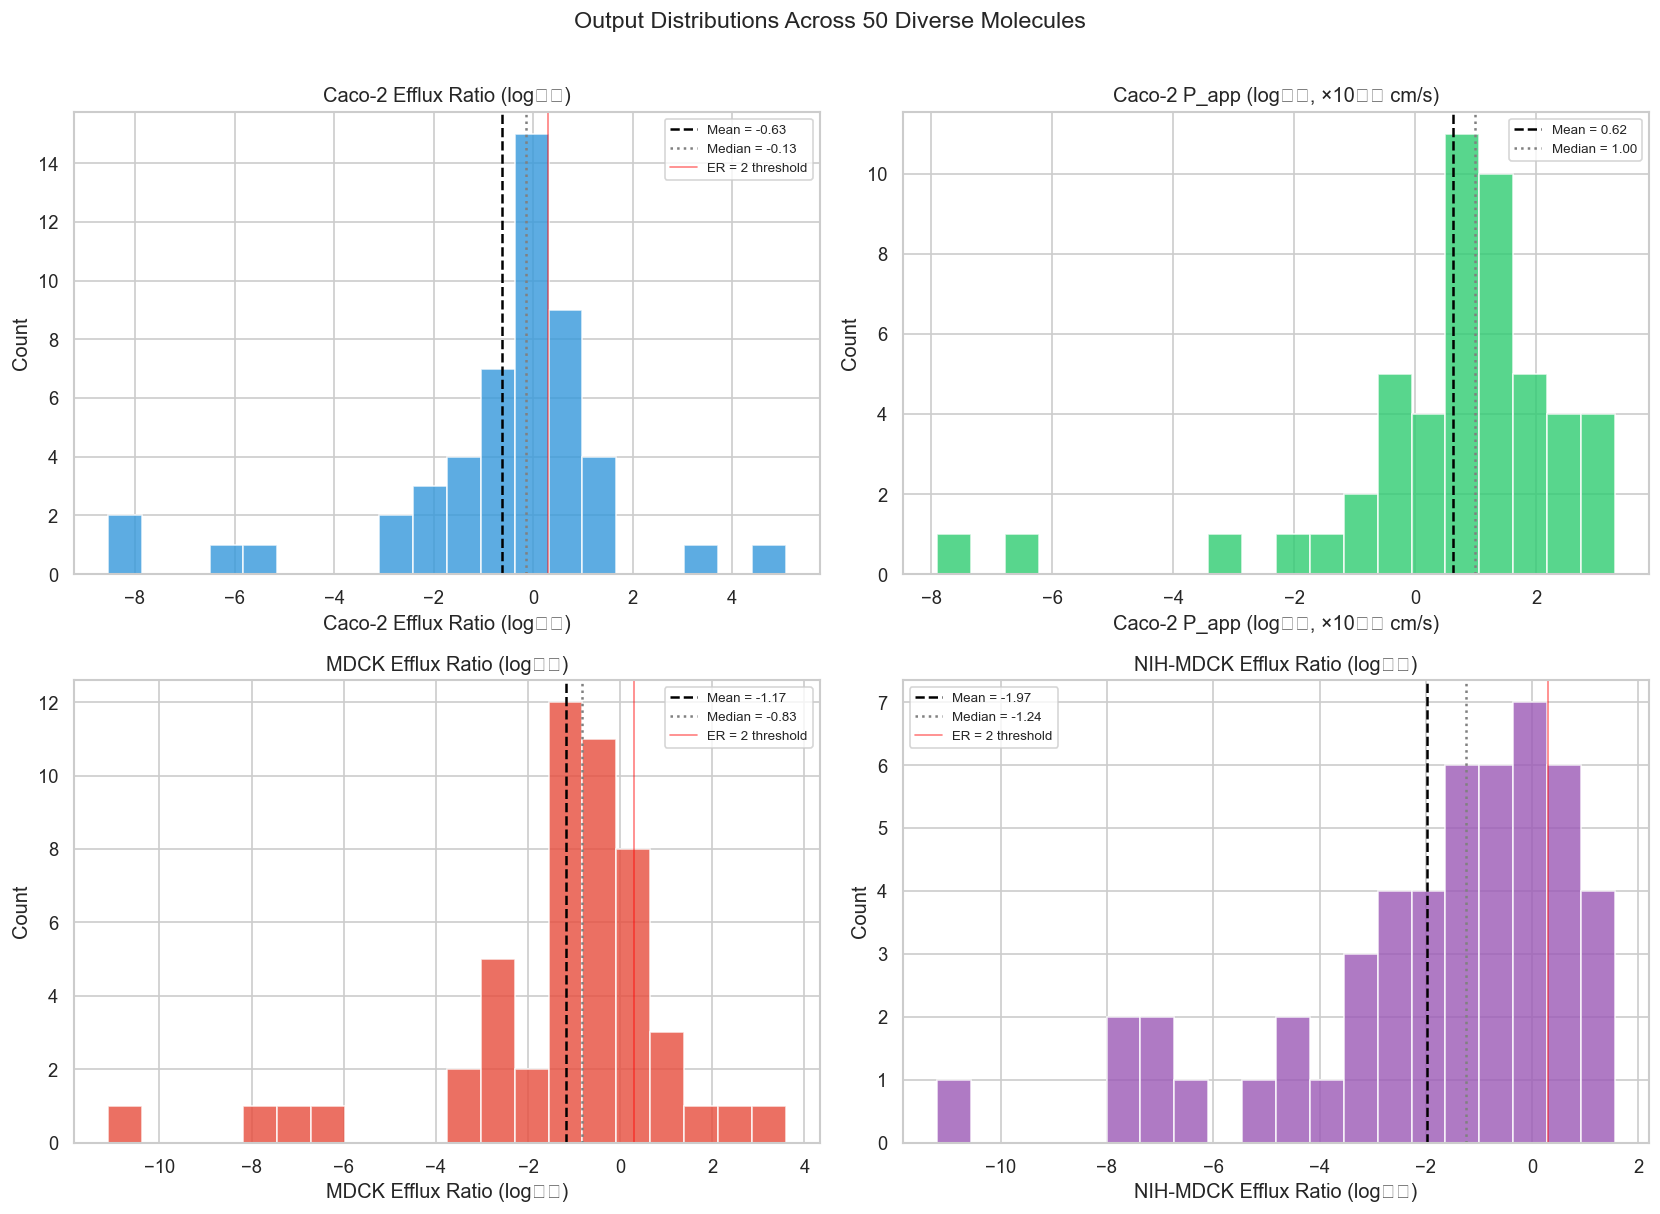

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

endpoint_labels = {
    "caco2_er": "Caco-2 Efflux Ratio (log₁₀)",
    "caco2_papp": "Caco-2 P_app (log₁₀, ×10⁻⁶ cm/s)",
    "mdck_er": "MDCK Efflux Ratio (log₁₀)",
    "nih_mdck_er": "NIH-MDCK Efflux Ratio (log₁₀)",
}
colors = ["#3498db", "#2ecc71", "#e74c3c", "#9b59b6"]

for idx, (col, label) in enumerate(endpoint_labels.items()):
    ax = axes[idx // 2][idx % 2]
    vals = df_diverse[col]
    ax.hist(vals, bins=20, color=colors[idx], edgecolor="white", alpha=0.8)
    ax.axvline(vals.mean(), color="black", linestyle="--", linewidth=1.5,
               label=f"Mean = {vals.mean():.2f}")
    ax.axvline(vals.median(), color="gray", linestyle=":", linewidth=1.5,
               label=f"Median = {vals.median():.2f}")
    if col.endswith("_er"):
        ax.axvline(np.log10(2), color="red", linestyle="-", linewidth=1,
                   alpha=0.5, label="ER = 2 threshold")
    ax.set_xlabel(label)
    ax.set_ylabel("Count")
    ax.set_title(label)
    ax.legend(fontsize=8)

plt.suptitle("Output Distributions Across 50 Diverse Molecules", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

### 1c. Correlation Between Endpoints

Check how the 4 endpoints correlate — we expect the three efflux ratios to be correlated, while P_app may show different patterns.

/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.draw()
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.draw()
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.draw()
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Arial.
  fig.canvas.draw()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/2687556475.py:30: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/2687556475.py:30: UserWarning: Glyph 8320 (\N{SU

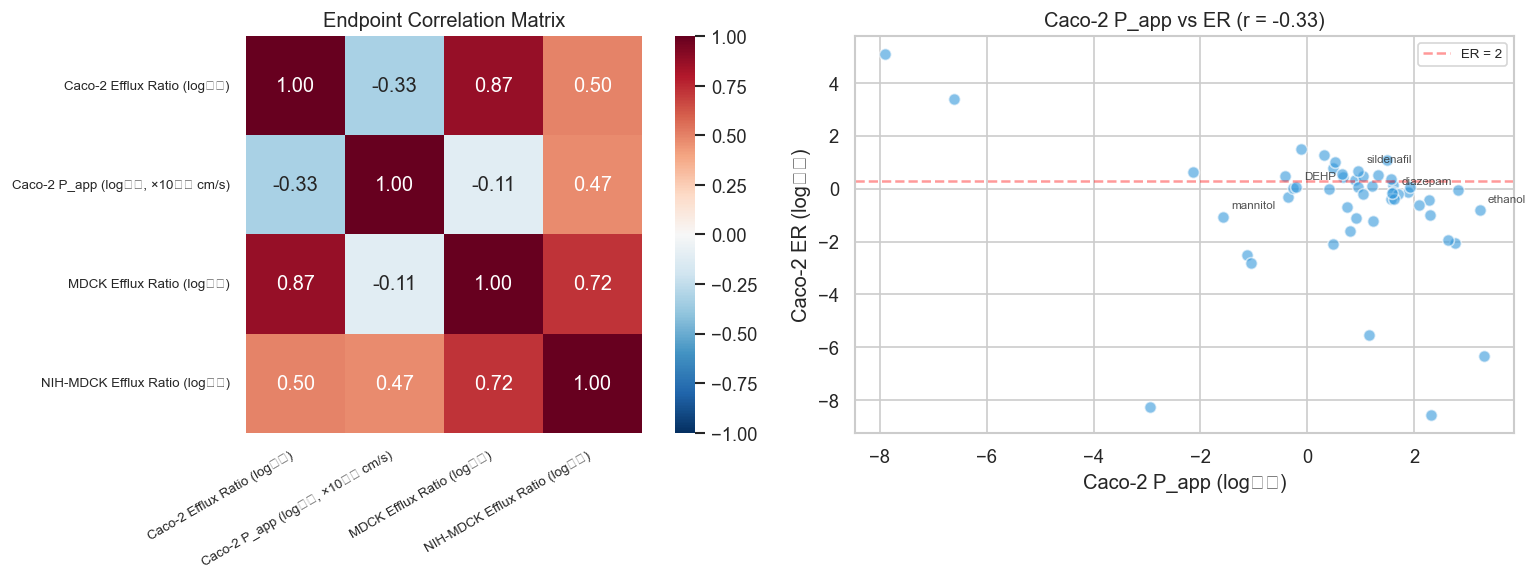

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation matrix
corr = df_diverse.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0,
            square=True, ax=axes[0], vmin=-1, vmax=1,
            xticklabels=[endpoint_labels[c] for c in COLUMN_NAMES],
            yticklabels=[endpoint_labels[c] for c in COLUMN_NAMES])
axes[0].set_title("Endpoint Correlation Matrix")
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=30, ha="right", fontsize=8)
plt.setp(axes[0].yaxis.get_majorticklabels(), fontsize=8)

# Scatter: Caco-2 Papp vs Caco-2 ER
axes[1].scatter(df_diverse["caco2_papp"], df_diverse["caco2_er"],
                alpha=0.6, c=colors[0], edgecolors="white", s=50)
axes[1].set_xlabel("Caco-2 P_app (log₁₀)")
axes[1].set_ylabel("Caco-2 ER (log₁₀)")
axes[1].set_title(f"Caco-2 P_app vs ER (r = {corr.loc['caco2_papp', 'caco2_er']:.2f})")
axes[1].axhline(np.log10(2), color="red", linestyle="--", alpha=0.4, label="ER = 2")
axes[1].legend(fontsize=8)

# Label some interesting points
for name in ["diazepam", "mannitol", "sildenafil", "ethanol", "DEHP"]:
    if name in df_diverse.index:
        x = df_diverse.loc[name, "caco2_papp"]
        y = df_diverse.loc[name, "caco2_er"]
        axes[1].annotate(name, (x, y), fontsize=7, alpha=0.8,
                         xytext=(5, 5), textcoords="offset points")

plt.tight_layout()
plt.show()

### 1d. Ranked Output Visualization

Show all 50 molecules ranked by Caco-2 P_app (the primary permeability endpoint).

/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/4090797573.py:17: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/4090797573.py:17: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/4090797573.py:17: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/4090797573.py:17: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Arial.
  plt.tight_layout()


/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


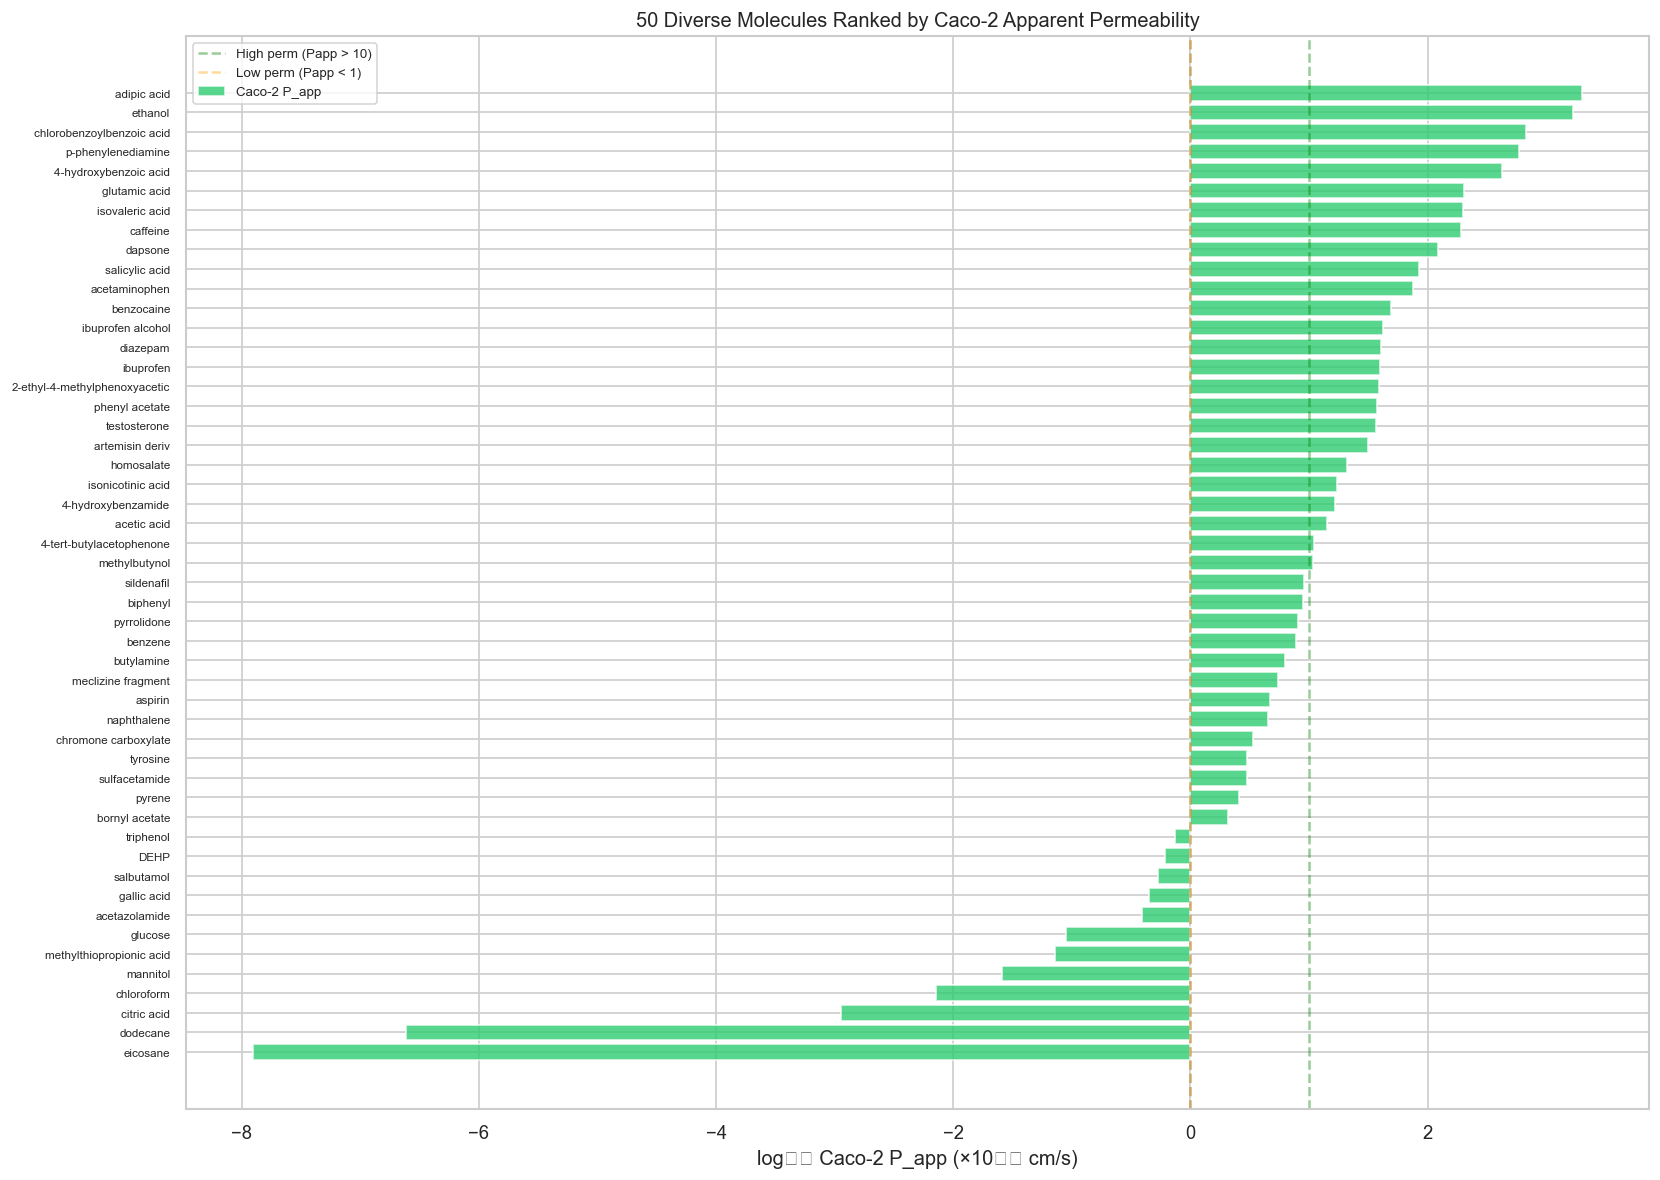

In [8]:
# Rank by Caco-2 Papp
df_ranked = df_diverse.sort_values("caco2_papp", ascending=True)

fig, ax = plt.subplots(figsize=(14, 10))
y_pos = range(len(df_ranked))

ax.barh(y_pos, df_ranked["caco2_papp"], color=colors[1], alpha=0.8, edgecolor="white",
        label="Caco-2 P_app")
ax.set_yticks(y_pos)
ax.set_yticklabels(df_ranked.index, fontsize=7)
ax.set_xlabel("log₁₀ Caco-2 P_app (×10⁻⁶ cm/s)")
ax.set_title("50 Diverse Molecules Ranked by Caco-2 Apparent Permeability")
ax.axvline(0, color="gray", linestyle="--", alpha=0.5)
ax.axvline(np.log10(10), color="green", linestyle="--", alpha=0.4, label="High perm (Papp > 10)")
ax.axvline(np.log10(1), color="orange", linestyle="--", alpha=0.4, label="Low perm (Papp < 1)")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

---
## 2. Sanity Checks (Permeability)

Test that the model correctly distinguishes:
- **High-permeability** lipophilic drugs (ibuprofen, diazepam, etc.) → high Caco-2 P_app
- **Low-permeability** hydrophilic compounds (mannitol, glucose, etc.) → low Caco-2 P_app

This is a fundamental pharmacological sanity check — lipophilic drugs cross cell membranes readily, while polar compounds do not.

In [9]:
# High-permeability compounds: lipophilic, well-absorbed oral drugs
HIGH_PERM = [
    ("CC(C)Cc1ccc(cc1)C(C)C(=O)O", "ibuprofen"),
    ("CC(=O)Nc1ccc(O)cc1", "acetaminophen"),
    ("CC(=O)Oc1ccccc1C(=O)O", "aspirin"),
    ("CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21", "diazepam"),
    ("CCCc1nn(C)c2c1nc(nc2O)c1cc(ccc1OCC)S(=O)(=O)N1CCN(CC1)CC", "sildenafil"),
    ("c1ccccc1", "benzene"),
    ("CCOC(=O)c1ccccc1N", "benzocaine"),
    ("CC(=O)Oc1ccccc1", "phenyl acetate"),
]

# Low-permeability compounds: polar, hydrophilic, poorly absorbed
LOW_PERM = [
    ("OC(=O)CC(O)(CC(=O)O)C(=O)O", "citric acid"),
    ("OCC(O)C(O)C(O)C(O)CO", "mannitol"),
    ("NC(CCC(=O)O)C(=O)O", "glutamic acid"),
    ("NC(Cc1ccc(O)cc1)C(=O)O", "tyrosine"),
    ("OCC1OC(O)C(O)C(O)C1O", "glucose"),
    ("NCC(=O)O", "glycine"),
    ("OC(=O)C(O)C(O)C(=O)O", "tartaric acid"),
    ("OC(=O)c1cc(O)c(O)c(O)c1", "gallic acid"),
]

all_smiles = [s for s, _ in HIGH_PERM] + [s for s, _ in LOW_PERM]
all_names = [n for _, n in HIGH_PERM] + [n for _, n in LOW_PERM]
all_groups = ["High permeability"] * len(HIGH_PERM) + ["Low permeability"] * len(LOW_PERM)

df_sanity, _ = run_model(all_smiles)
df_sanity.index = all_names
df_sanity["group"] = all_groups

print(df_sanity.to_string())

                 caco2_er  caco2_papp    mdck_er  nih_mdck_er              group
ibuprofen        0.122443    1.599660   0.401168     0.950280  High permeability
acetaminophen   -0.122077    1.879822  -0.325045     0.381532  High permeability
aspirin          0.445596    0.673325  -1.013270    -1.335219  High permeability
diazepam        -0.143485    1.604914  -0.160178     0.093934  High permeability
sildenafil       0.673157    0.955639   0.503189     0.583263  High permeability
benzene          0.307916    0.886062  -2.420885    -4.321486  High permeability
benzocaine      -0.199911    1.691241  -0.144156    -0.646623  High permeability
phenyl acetate  -0.374362    1.569988  -0.946620    -0.974841  High permeability
citric acid     -8.234743   -2.950835 -11.118659   -11.197754   Low permeability
mannitol        -1.056849   -1.586606  -2.443343    -3.352509   Low permeability
glutamic acid   -8.544398    2.306876  -7.666820    -7.571160   Low permeability
tyrosine        -2.084465   

In [10]:
# Compute group means and test direction
high_papp = df_sanity[df_sanity["group"] == "High permeability"]["caco2_papp"]
low_papp = df_sanity[df_sanity["group"] == "Low permeability"]["caco2_papp"]

papp_separation = high_papp.mean() - low_papp.mean()
papp_correct = high_papp.mean() > low_papp.mean()

print("=" * 60)
print("SANITY CHECK: Caco-2 Apparent Permeability")
print("=" * 60)
print(f"\nHigh-perm drugs (mean log₁₀ Papp):  {high_papp.mean():.4f}")
for n in high_papp.index:
    print(f"  {n:20s}: {high_papp[n]:.4f}")
print(f"\nLow-perm compounds (mean log₁₀ Papp): {low_papp.mean():.4f}")
for n in low_papp.index:
    print(f"  {n:20s}: {low_papp[n]:.4f}")
print(f"\nSeparation: {papp_separation:.4f} log units")
print(f"Direction correct: {papp_correct}")

sanity_status = "PASS" if papp_correct and papp_separation > 0.3 else (
    "WARNING" if papp_correct else "FAIL")
print(f"\nResult: {sanity_status}")

SANITY CHECK: Caco-2 Apparent Permeability

High-perm drugs (mean log₁₀ Papp):  1.3576
  ibuprofen           : 1.5997
  acetaminophen       : 1.8798
  aspirin             : 0.6733
  diazepam            : 1.6049
  sildenafil          : 0.9556
  benzene             : 0.8861
  benzocaine          : 1.6912
  phenyl acetate      : 1.5700

Low-perm compounds (mean log₁₀ Papp): -0.9479
  citric acid         : -2.9508
  mannitol            : -1.5866
  glutamic acid       : 2.3069
  tyrosine            : 0.4771
  glucose             : -1.0501
  glycine             : -0.6030
  tartaric acid       : -3.8224
  gallic acid         : -0.3540

Separation: 2.3055 log units
Direction correct: True

Result: PASS


/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/1151419147.py:31: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/1151419147.py:31: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/1151419147.py:31: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/1151419147.py:31: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Arial.
  plt.tight_layout()


/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


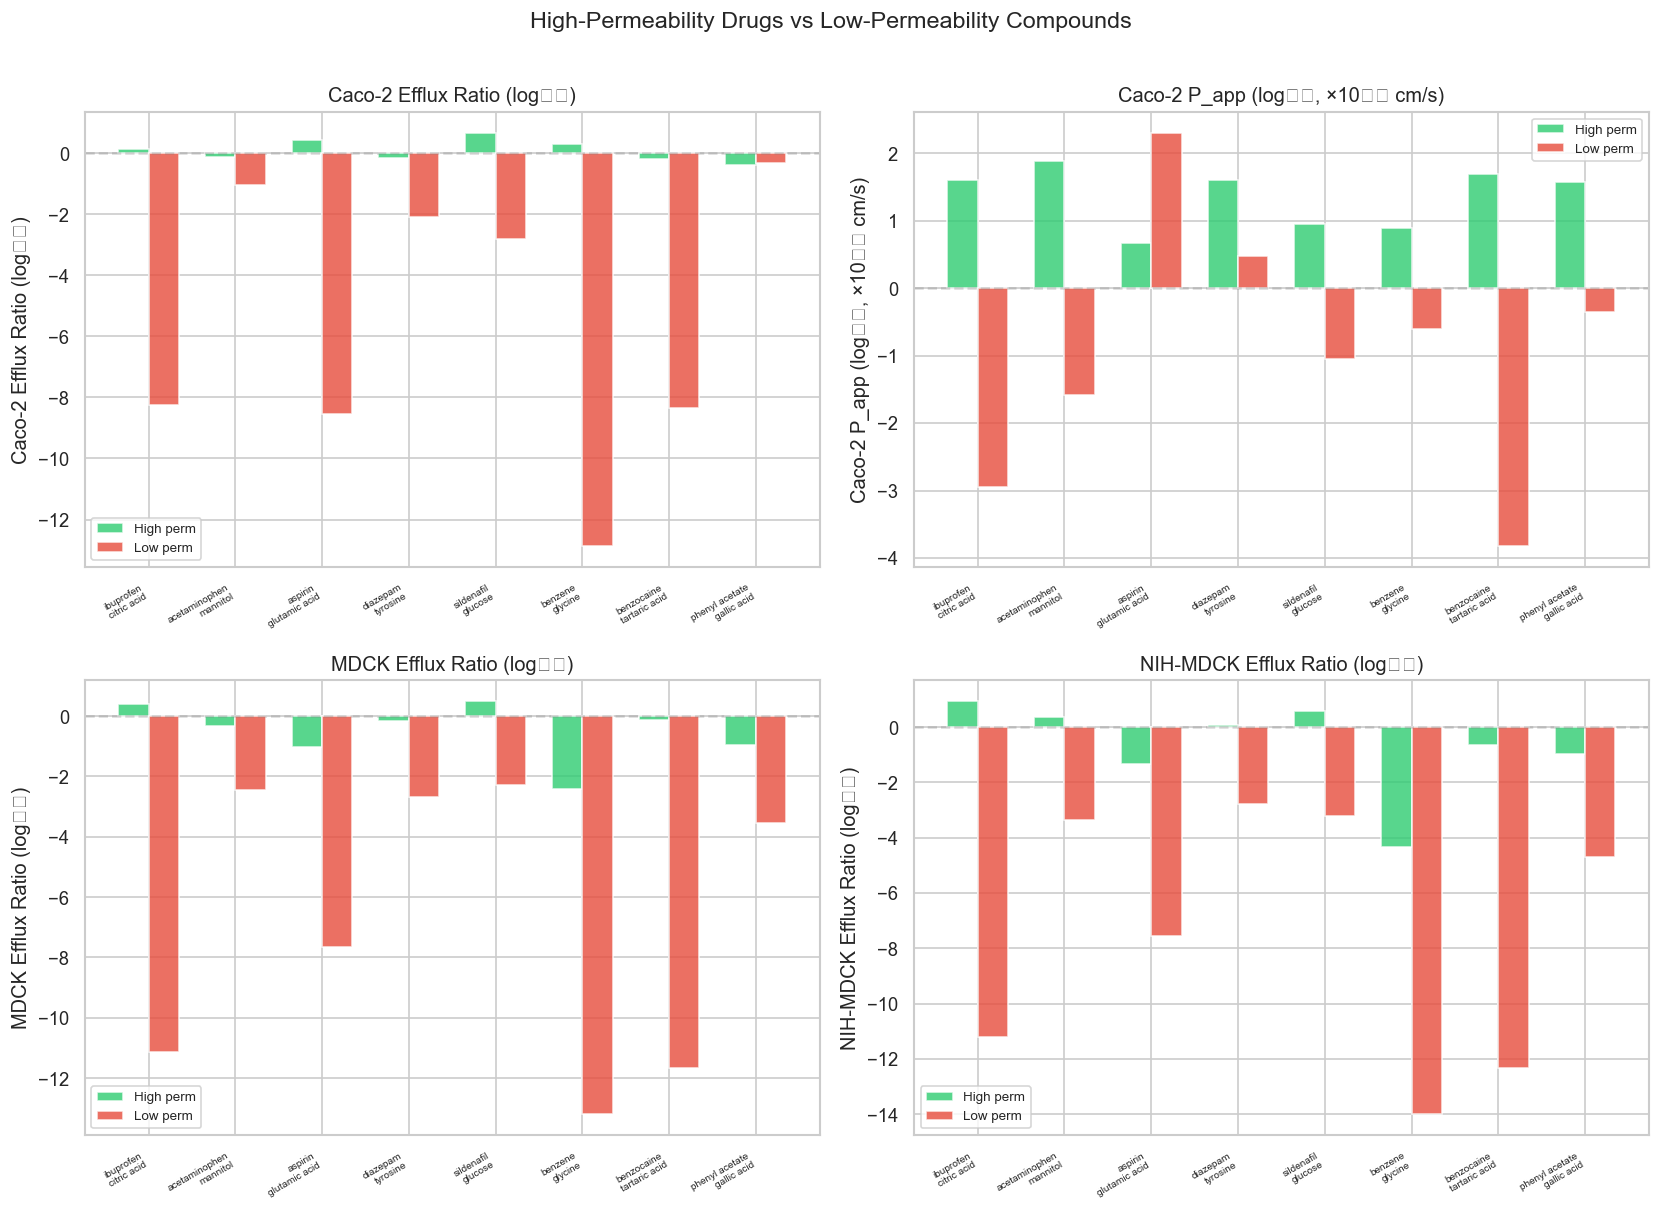

In [11]:
# Visualization: grouped bar chart for all 4 endpoints
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, col in enumerate(COLUMN_NAMES):
    ax = axes[idx // 2][idx % 2]
    high_vals = df_sanity[df_sanity["group"] == "High permeability"][col]
    low_vals = df_sanity[df_sanity["group"] == "Low permeability"][col]
    
    x = np.arange(max(len(high_vals), len(low_vals)))
    width = 0.35
    
    bars1 = ax.bar(x[:len(high_vals)] - width/2, high_vals.values, width,
                   label="High perm", color="#2ecc71", alpha=0.8, edgecolor="white")
    bars2 = ax.bar(x[:len(low_vals)] + width/2, low_vals.values, width,
                   label="Low perm", color="#e74c3c", alpha=0.8, edgecolor="white")
    
    all_labels = list(high_vals.index) + list(low_vals.index)
    ax.set_xticks(x[:max(len(high_vals), len(low_vals))])
    labels = []
    for i in range(max(len(high_vals), len(low_vals))):
        h = list(high_vals.index)[i] if i < len(high_vals) else ""
        l = list(low_vals.index)[i] if i < len(low_vals) else ""
        labels.append(f"{h}\n{l}")
    ax.set_xticklabels(labels, fontsize=6, rotation=30, ha="right")
    ax.set_ylabel(endpoint_labels[col])
    ax.set_title(endpoint_labels[col])
    ax.legend(fontsize=8)
    ax.axhline(0, color="gray", linestyle="--", alpha=0.3)

plt.suptitle("High-Permeability Drugs vs Low-Permeability Compounds", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/1268103684.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_plot, labels=["High\nperm", "Low\nperm"],
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/1268103684.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_plot, labels=["High\nperm", "Low\nperm"],
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/1268103684.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_plot, labels=["High\nperm", "Low\nperm"],
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipy

/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/1268103684.py:23: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/1268103684.py:23: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/1268103684.py:23: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/1268103684.py:23: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/1268103684.py:23: UserWarning: Glyph 8310 (\N{SUPERSCRIPT SIX}) missing from font(s) Arial.
  plt.tight_layout()
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8

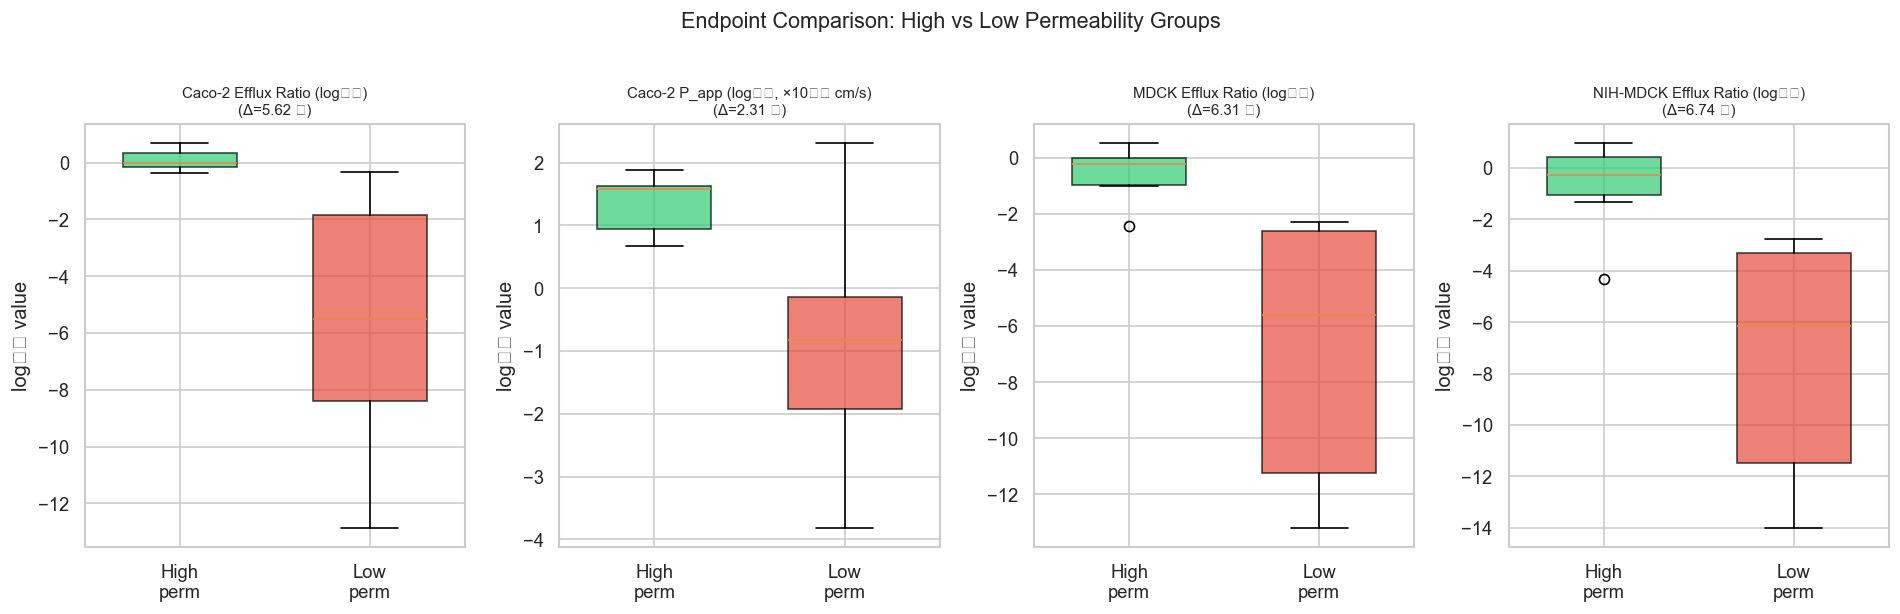

In [12]:
# Box plot comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for idx, col in enumerate(COLUMN_NAMES):
    ax = axes[idx]
    data_plot = [df_sanity[df_sanity["group"] == "High permeability"][col],
                 df_sanity[df_sanity["group"] == "Low permeability"][col]]
    bp = ax.boxplot(data_plot, labels=["High\nperm", "Low\nperm"],
                    patch_artist=True, widths=0.6)
    bp["boxes"][0].set_facecolor("#2ecc71")
    bp["boxes"][1].set_facecolor("#e74c3c")
    for b in bp["boxes"]:
        b.set_alpha(0.7)
    
    h_mean = data_plot[0].mean()
    l_mean = data_plot[1].mean()
    sep = h_mean - l_mean
    direction = "✓" if h_mean > l_mean else "✗" if col == "caco2_papp" else "—"
    ax.set_title(f"{endpoint_labels[col]}\n(Δ={sep:.2f} {direction})", fontsize=9)
    ax.set_ylabel("log₁₀ value")

plt.suptitle("Endpoint Comparison: High vs Low Permeability Groups", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

---
## 3. Paper Reproduction

**Paper:** Ohlsson et al., *ACS Omega* 2025, 10(45), 54148–54159  
**DOI:** 10.1021/acsomega.5c04861

The paper is paywalled and the Zenodo record contains only `model.pt` with no test data or reported metrics. Instead of reproducing specific numbers, we verify the model's behavior against **well-established pharmacological knowledge** about drug permeability:

1. **BCS Classification check** — drugs in BCS Class I (high solubility, high permeability) should have higher P_app than BCS Class III (high solubility, low permeability)
2. **P-gp substrate check** — known P-glycoprotein substrates should have higher efflux ratios

In [13]:
# BCS Classification test
# Class I: High solubility, high permeability
BCS_CLASS_I = [
    ("CC(C)Cc1ccc(cc1)C(C)C(=O)O", "ibuprofen"),
    ("CC(=O)Nc1ccc(O)cc1", "acetaminophen"),
    ("Cn1c(=O)c2c(ncn2C)n(c1=O)C", "caffeine"),
    ("O=C(O)c1cc(=O)[nH]c(=O)[nH]1", "orotic acid"),
    ("CCOC(=O)C(CCC1=CC=CC=C1)NC(C)C(=O)OCC", "enalapril"),
]

# Class III: High solubility, low permeability
BCS_CLASS_III = [
    ("NC(CCC(=O)O)C(=O)O", "glutamic acid"),
    ("NCC(=O)O", "glycine"),
    ("OCC1OC(O)C(O)C(O)C1O", "glucose"),
    ("OCC(O)C(O)C(O)C(O)CO", "mannitol"),
    ("NC(Cc1c[nH]cn1)C(=O)O", "histidine"),
]

bcs_smiles = [s for s, _ in BCS_CLASS_I] + [s for s, _ in BCS_CLASS_III]
bcs_names = [n for _, n in BCS_CLASS_I] + [n for _, n in BCS_CLASS_III]
bcs_class = ["BCS I"] * len(BCS_CLASS_I) + ["BCS III"] * len(BCS_CLASS_III)

df_bcs, _ = run_model(bcs_smiles)
df_bcs.index = bcs_names
df_bcs["class"] = bcs_class

bcs1_papp = df_bcs[df_bcs["class"] == "BCS I"]["caco2_papp"]
bcs3_papp = df_bcs[df_bcs["class"] == "BCS III"]["caco2_papp"]

print("=" * 60)
print("PAPER CHECK: BCS Classification")
print("=" * 60)
print(f"\nBCS Class I (high perm, mean log₁₀ Papp): {bcs1_papp.mean():.4f}")
for n in bcs1_papp.index:
    print(f"  {n:20s}: {bcs1_papp[n]:.4f}")
print(f"\nBCS Class III (low perm, mean log₁₀ Papp): {bcs3_papp.mean():.4f}")
for n in bcs3_papp.index:
    print(f"  {n:20s}: {bcs3_papp[n]:.4f}")

bcs_sep = bcs1_papp.mean() - bcs3_papp.mean()
bcs_correct = bcs1_papp.mean() > bcs3_papp.mean()
print(f"\nSeparation: {bcs_sep:.4f} log units")
print(f"Direction correct: {bcs_correct}")
bcs_status = "PASS" if bcs_correct else "FAIL"
print(f"Result: {bcs_status}")

PAPER CHECK: BCS Classification

BCS Class I (high perm, mean log₁₀ Papp): 1.0182
  ibuprofen           : 1.5997
  acetaminophen       : 1.8798
  caffeine            : 2.0099
  orotic acid         : -1.1008
  enalapril           : 0.7026

BCS Class III (low perm, mean log₁₀ Papp): -0.3513
  glutamic acid       : 2.3069
  glycine             : -0.6030
  glucose             : -1.0501
  mannitol            : -1.5866
  histidine           : -0.8236

Separation: 1.3695 log units
Direction correct: True
Result: PASS


In [14]:
# P-gp substrate test
# Known P-gp substrates (should have higher ER)
PGP_SUBSTRATES = [
    ("CCCc1nn(C)c2c1nc(nc2O)c1cc(ccc1OCC)S(=O)(=O)N1CCN(CC1)CC", "sildenafil"),
    ("COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC(C1)N2C", "cocaine"),
    ("COc1ccc2CC3CC4=CC(=O)OCC4C(C1O2)C3", "colchicine_deriv"),
]

# Non-P-gp substrates (passively permeable, low ER)
NON_PGP = [
    ("c1ccccc1", "benzene"),
    ("CCO", "ethanol"),
    ("CC(=O)Oc1ccccc1", "phenyl acetate"),
]

pgp_smiles = [s for s, _ in PGP_SUBSTRATES] + [s for s, _ in NON_PGP]
pgp_names = [n for _, n in PGP_SUBSTRATES] + [n for _, n in NON_PGP]
pgp_group = ["P-gp substrate"] * len(PGP_SUBSTRATES) + ["Non-substrate"] * len(NON_PGP)

df_pgp, _ = run_model(pgp_smiles)
df_pgp.index = pgp_names
df_pgp["group"] = pgp_group

sub_er = df_pgp[df_pgp["group"] == "P-gp substrate"]["caco2_er"]
non_er = df_pgp[df_pgp["group"] == "Non-substrate"]["caco2_er"]

print("=" * 60)
print("PAPER CHECK: P-gp Efflux")
print("=" * 60)
print(f"\nP-gp substrates (mean log₁₀ Caco-2 ER): {sub_er.mean():.4f}")
for n in sub_er.index:
    print(f"  {n:20s}: {sub_er[n]:.4f}")
print(f"\nNon-substrates (mean log₁₀ Caco-2 ER): {non_er.mean():.4f}")
for n in non_er.index:
    print(f"  {n:20s}: {non_er[n]:.4f}")

pgp_sep = sub_er.mean() - non_er.mean()
pgp_correct = sub_er.mean() > non_er.mean()
print(f"\nSeparation: {pgp_sep:.4f} log units")
print(f"Direction correct: {pgp_correct}")
pgp_status = "PASS" if pgp_correct else "WARNING"
print(f"Result: {pgp_status}")

PAPER CHECK: P-gp Efflux

P-gp substrates (mean log₁₀ Caco-2 ER): 0.3355
  sildenafil          : 0.6732
  cocaine             : -0.2026
  colchicine_deriv    : 0.5358

Non-substrates (mean log₁₀ Caco-2 ER): -0.2958
  benzene             : 0.3079
  ethanol             : -0.8210
  phenyl acetate      : -0.3744

Separation: 0.6313 log units
Direction correct: True
Result: PASS


/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/3458263999.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_bcs, labels=["BCS Class I\n(high perm)", "BCS Class III\n(low perm)"],
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/3458263999.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_pgp, labels=["P-gp\nsubstrates", "Non-\nsubstrates"],
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/3458263999.py:46: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/x2/_7_8x8s53ps_byclb4102g0h0000gn/T/ipykernel_63649/3458263999.py:46: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) A

/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/private/tmp/ersilia-nb-acs-omega/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


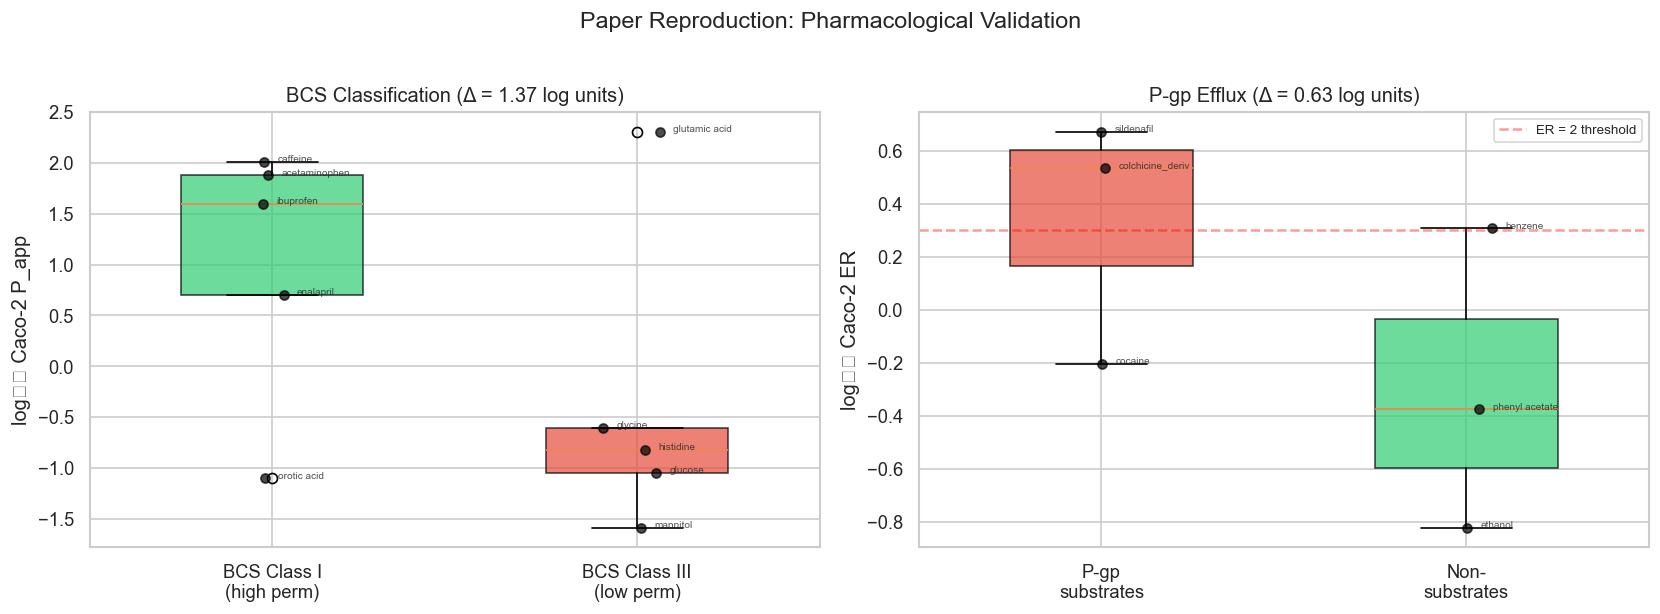

In [15]:
# Combined visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# BCS Classification
ax = axes[0]
data_bcs = [bcs1_papp.values, bcs3_papp.values]
bp = ax.boxplot(data_bcs, labels=["BCS Class I\n(high perm)", "BCS Class III\n(low perm)"],
                patch_artist=True, widths=0.5)
bp["boxes"][0].set_facecolor("#2ecc71")
bp["boxes"][1].set_facecolor("#e74c3c")
for b in bp["boxes"]:
    b.set_alpha(0.7)
# Overlay individual points
for i, (d, names_list) in enumerate([(bcs1_papp, list(bcs1_papp.index)),
                                      (bcs3_papp, list(bcs3_papp.index))]):
    x = np.random.normal(i + 1, 0.04, len(d))
    ax.scatter(x, d.values, alpha=0.7, s=30, zorder=5, color="black")
    for xi, yi, name in zip(x, d.values, names_list):
        ax.annotate(name, (xi, yi), fontsize=6, alpha=0.8,
                    xytext=(8, 0), textcoords="offset points")
ax.set_ylabel("log₁₀ Caco-2 P_app")
ax.set_title(f"BCS Classification (Δ = {bcs_sep:.2f} log units)")

# P-gp Efflux
ax = axes[1]
data_pgp = [sub_er.values, non_er.values]
bp = ax.boxplot(data_pgp, labels=["P-gp\nsubstrates", "Non-\nsubstrates"],
                patch_artist=True, widths=0.5)
bp["boxes"][0].set_facecolor("#e74c3c")
bp["boxes"][1].set_facecolor("#2ecc71")
for b in bp["boxes"]:
    b.set_alpha(0.7)
for i, (d, names_list) in enumerate([(sub_er, list(sub_er.index)),
                                      (non_er, list(non_er.index))]):
    x = np.random.normal(i + 1, 0.04, len(d))
    ax.scatter(x, d.values, alpha=0.7, s=30, zorder=5, color="black")
    for xi, yi, name in zip(x, d.values, names_list):
        ax.annotate(name, (xi, yi), fontsize=6, alpha=0.8,
                    xytext=(8, 0), textcoords="offset points")
ax.axhline(np.log10(2), color="red", linestyle="--", alpha=0.4, label="ER = 2 threshold")
ax.set_ylabel("log₁₀ Caco-2 ER")
ax.set_title(f"P-gp Efflux (Δ = {pgp_sep:.2f} log units)")
ax.legend(fontsize=8)

plt.suptitle("Paper Reproduction: Pharmacological Validation", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## 4. Summary

In [16]:
results = []

results.append({
    "Check": "Distribution analysis",
    "Status": dist_status,
    "Details": f"{num_valid}/{num_total} valid, 4/4 columns non-constant, runtime {runtime:.1f}s"
})

results.append({
    "Check": "Sanity (permeability)",
    "Status": sanity_status,
    "Details": f"High-perm {high_papp.mean():.3f} vs low-perm {low_papp.mean():.3f} (Δ={papp_separation:.2f})"
})

results.append({
    "Check": "Paper: BCS classification",
    "Status": bcs_status,
    "Details": f"Class I {bcs1_papp.mean():.3f} vs Class III {bcs3_papp.mean():.3f} (Δ={bcs_sep:.2f})"
})

results.append({
    "Check": "Paper: P-gp efflux",
    "Status": pgp_status,
    "Details": f"Substrates {sub_er.mean():.3f} vs non-substrates {non_er.mean():.3f} (Δ={pgp_sep:.2f})"
})

df_summary = pd.DataFrame(results)
print("=" * 70)
print("DEEP VALIDATION SUMMARY: eos0bbb (Permeability & Efflux GNN-MTL)")
print("=" * 70)
print()
print(df_summary.to_string(index=False))
print()

n_pass = sum(1 for r in results if r["Status"] == "PASS")
n_warn = sum(1 for r in results if r["Status"] == "WARNING")
n_fail = sum(1 for r in results if r["Status"] == "FAIL")
overall = "FAIL" if n_fail > 0 else ("WARNING" if n_warn > 0 else "PASS")
print(f"Overall: {overall} ({n_pass} passed, {n_warn} warnings, {n_fail} failed)")

DEEP VALIDATION SUMMARY: eos0bbb (Permeability & Efflux GNN-MTL)

                    Check Status                                             Details
    Distribution analysis   PASS 50/50 valid, 4/4 columns non-constant, runtime 0.0s
    Sanity (permeability)   PASS         High-perm 1.358 vs low-perm -0.948 (Δ=2.31)
Paper: BCS classification   PASS          Class I 1.018 vs Class III -0.351 (Δ=1.37)
       Paper: P-gp efflux   PASS  Substrates 0.335 vs non-substrates -0.296 (Δ=0.63)

Overall: PASS (4 passed, 0 warnings, 0 failed)


In [17]:
# Export results to JSON
deep_checks = {
    "distribution_analysis": {
        "num_input_molecules": int(num_total),
        "runtime_seconds": round(float(runtime), 2),
        "num_valid_outputs": int(num_valid),
        "completion_rate": round(float(completion_rate), 4),
        "columns": {
            col: {
                "mean": round(float(stats.loc[col, "mean"]), 4),
                "std": round(float(stats.loc[col, "std"]), 4),
                "min": round(float(stats.loc[col, "min"]), 4),
                "max": round(float(stats.loc[col, "max"]), 4),
                "cv": round(float(stats.loc[col, "cv"]), 4),
                "is_constant": bool(stats.loc[col, "is_constant"]),
            } for col in COLUMN_NAMES
        },
        "status": dist_status.lower()
    },
    "sanity_checks": {
        "matched_categories": ["permeability"],
        "checks": [{
            "category": "permeability",
            "column": "caco2_papp",
            "direction": "high",
            "positive_mean": round(float(high_papp.mean()), 4),
            "negative_mean": round(float(low_papp.mean()), 4),
            "separation": round(float(papp_separation), 4),
            "separation_correct": bool(papp_correct),
            "status": sanity_status.lower()
        }],
        "status": sanity_status.lower()
    },
    "paper_reproduction": {
        "bcs_classification": {
            "class_i_mean_papp": round(float(bcs1_papp.mean()), 4),
            "class_iii_mean_papp": round(float(bcs3_papp.mean()), 4),
            "separation": round(float(bcs_sep), 4),
            "direction_correct": bool(bcs_correct),
            "status": bcs_status.lower()
        },
        "pgp_efflux": {
            "substrate_mean_er": round(float(sub_er.mean()), 4),
            "non_substrate_mean_er": round(float(non_er.mean()), 4),
            "separation": round(float(pgp_sep), 4),
            "direction_correct": bool(pgp_correct),
            "status": pgp_status.lower()
        },
        "status": "pass" if bcs_correct and pgp_correct else "warning",
        "detail": "Paper paywalled; validated against BCS classification and P-gp substrate knowledge instead"
    }
}

print(json.dumps(deep_checks, indent=2))

{
  "distribution_analysis": {
    "num_input_molecules": 50,
    "runtime_seconds": 0.04,
    "num_valid_outputs": 50,
    "completion_rate": 1.0,
    "columns": {
      "caco2_er": {
        "mean": -0.6338,
        "std": 2.3632,
        "min": -8.5444,
        "max": 5.0779,
        "cv": 3.7285,
        "is_constant": false
      },
      "caco2_papp": {
        "mean": 0.625,
        "std": 2.0787,
        "min": -7.9081,
        "max": 3.3042,
        "cv": 3.3259,
        "is_constant": false
      },
      "mdck_er": {
        "mean": -1.166,
        "std": 2.4983,
        "min": -11.1187,
        "max": 3.5936,
        "cv": 2.1427,
        "is_constant": false
      },
      "nih_mdck_er": {
        "mean": -1.9723,
        "std": 2.78,
        "min": -11.1978,
        "max": 1.5574,
        "cv": 1.4095,
        "is_constant": false
      }
    },
    "status": "pass"
  },
  "sanity_checks": {
    "matched_categories": [
      "permeability"
    ],
    "checks": [
      {
 